# Creating a network from Wikipedia pages

## Data Pipeline



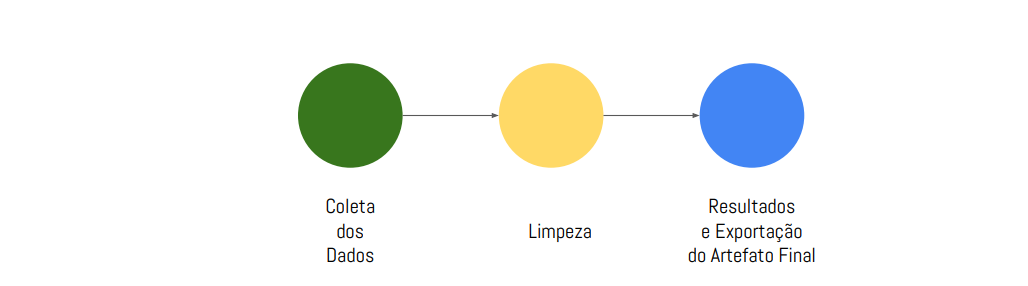

## Import libraries


In [40]:
!pip install wikipedia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
from operator import itemgetter
import networkx as nx
import wikipedia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
sns.set()

## Creating graph
This function receives the root called `SEED` and the stop criteria called `STOPS`, and with that generate a graph.

In [42]:
def create_graph(args: dict) -> nx.DiGraph:

  print("Creating graph...")

  todo_lst = [(0, args['SEED'])] # The SEED is in the layer 0
  todo_set = set(args['SEED']) # The SEED itself
  done_set = set() # Nothing is done yet

  g = nx.DiGraph()
  layer, page = todo_lst[0]

  if os.path.isfile('nodes.txt'):
    file = open('nodes.txt', 'w')
  else:
    file = open('nodes.txt', 'x')
    
  while layer < 2:
    # Remove the name page of the current page from the todo_lst, 
    # and add it to the set of processed pages. 
    # If the script encounters this page again, it will skip over it.
    del todo_lst[0]
    done_set.add(page)

    # writing progress on file
    file.write(f"{layer} {page}\n")

    # Attempt to download the selected page.
    try:
      wiki = wikipedia.page(page)
    except:
      print(f"Could not load {page}")
      layer, page = todo_lst[0]
      continue
    
    for link in wiki.links:
      link = link.title()
      if link not in args['STOPS'] and not link.startswith("List Of"):
        if link not in todo_set and link not in done_set:
          todo_lst.append((layer + 1, link))
          todo_set.add(link)
        g.add_edge(page, link)
    layer, page = todo_lst[0]

  # close the file
  file.close()
  
  return g

## Preprocessing
Some nodes come as duplicates but in plural or with - between the words. For example, `Asian Brazilian` and `Asian Brazilians` or even `Italian-Brazilian` and `Italian Brazilian`. So, this function search these nodes and contract them into only one.

In [43]:
def preprocessing(g: nx.DiGraph) -> nx.DiGraph:
  print("Preprocessing the Graph...")

  # remove self loops
  g.remove_edges_from(nx.selfloop_edges(g))

  # identify duplicates like that: 'network' and 'networks'
  duplicates = [(node, node + "s") 
                for node in g if node + "s" in g
              ]

  for dup in duplicates:
    # *dup is a technique named 'unpacking'
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  if os.path.isfile('duplicated_nodes.txt'):
    file2 = open('duplicated_nodes.txt', 'w')
  else:
    file2 = open('duplicated_nodes.txt', 'x')

  file2.write(f"{duplicates}")

  duplicates = [(x, y) for x, y in 
                [(node, node.replace("-", " ")) for node in g]
                  if x != y and y in g]

  file2.write(f"{duplicates}")

  for dup in duplicates:
    g = nx.contracted_nodes(g, *dup, self_loops=False)

  # nx.contracted creates a new node/edge attribute called contraction
  # the value of the attribute is a dictionary, but GraphML
  # does not support dictionary attributes
  nx.set_node_attributes(g, 0,"contraction")
  nx.set_edge_attributes(g, 0,"contraction")

  file2.close()
  return g

## Truncate the network
Most of the nodes in this network have only one connection. So, this function removes these nodes with only one incident edge to make the network more compact and less hairy without hurting the final results

In [44]:
def plot_histogram(g: nx.DiGraph):
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  ax[0].hist(degree_sequence)
  ax[1].hist(degree_sequence,bins=[1,2,3,4,5,6,7,8,9,10])

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")
  ax[0].set_ylim(0,80000)

  ax[1].set_title("Degree Histogram - Zoom")
  ax[1].set_ylabel("Count")
  ax[1].set_xlabel("Degree")
  ax[1].set_xlim(0,10)
  ax[1].set_ylim(0,60000)

  plt.tight_layout()
  plt.savefig('degree_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [45]:
def truncate(g: nx.DiGraph):

  plot_histogram(g)

  core = [node for node, deg in dict(g.degree()).items() if deg >= 2]

  gsub = nx.subgraph(g, core)

  print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

  nx.write_graphml(gsub, "cna.graphml")

  print("Nodes removed: {:.2f}%".format(100*(1 - len(gsub)/len(g))))
  print("Edges removed: {:.2f}%".format(100*(1 - nx.number_of_edges(gsub)/nx.number_of_edges(g))))
  print("Edges per nodes: {:.2f}".format(nx.number_of_edges(gsub)/len(gsub)))
     

## Exploring the network

### Most significant nodes and number of connections

In [46]:
def most_significant_nodes(g: nx.DiGraph):

  top_indegree = sorted(dict(g.in_degree()).items(),
                      reverse=True, key=itemgetter(1))[:100]

  if os.path.isfile('most_sig_nodes.txt'):
    file3 = open('most_sig_nodes.txt', 'w')
  else:
    file3 = open('most_sig_nodes.txt', 'x')

  file3.write("\n".join(map(lambda t: "{} {}".format(*reversed(t)), top_indegree)))
  file3.close()

## Degree, closeness, betweenness and eigenvector centrality
Since this network is very large, in order to visualize these metrics, it was necessary to use a tool called [Gephi](https://gephi.org/) to improve the visualization. However, below is the code that allows you to view these metrics using Python functions from the `networkx` and `matplotlib` libraries.

### Centrality distributions - Degree

In [47]:
def all_nodes_degree(g: nx.DiGraph):
  print("Exploring Centrality distributions - Degree - All Nodes")
  plt.style.use("default")
 
  degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Degree")

  plt.tight_layout()
  plt.savefig('degree_all_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  print("Ploting Probability Density Function (PDF) - All Nodes")
  plt.style.use("fivethirtyeight")

  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function_all_nodes.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  print("Ploting Cumulative Density Function (CDF) - All Nodes")
  fig, ax = plt.subplots(1,1,figsize=(7,6))
  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function_all_nodes.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [48]:
def degree_over_100(g: nx.DiGraph):
  print("Exploring Centrality distributions - Degree - Nodes with degree greater than or equal to 100")
  # filter nodes with degree greater than or equal to 100
  core = [node for node, deg in dict(g.degree()).items() if deg > 100]

  # select a subgraph with 'core' nodes
  gsub = nx.subgraph(g, core)

  print("{} nodes, {} edges".format(len(gsub), nx.number_of_edges(gsub)))

  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([d for n, d in gsub.degree()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,6))

  # all_data has information about degree_sequence and the width of each bin
  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Degree Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Degree")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Degree")

  plt.tight_layout()
  plt.savefig('degree_100_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Probability Density Function (PDF)
  print("Ploting Probability Density Function (PDF) - Nodes 100")
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('probability_density_function_nodes_100.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Cumulative Density Function (CDF)
  print("Ploting Cumulative Density Function (CDF) - Nodes 100")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Degree")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function_nodes_100.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

In [49]:
def degree(g: nx.DiGraph):
  print("Exploring Centrality distributions - Degree")
  all_nodes_degree(g)
  degree_over_100(g)

### Centrality distributions - Closeness

In [50]:
def closeness(g: nx.DiGraph):
  print("Exploring Centrality distributions - Closeness")
  plt.style.use("default")
  # degree sequence
  degree_sequence = sorted([v for k, v in nx.closeness_centrality(g).items()], reverse=True)  

  fig, ax = plt.subplots(1,2,figsize=(8,4))

  # all_data has information about degree_sequence and the width of each bin
  all_data = ax[0].hist(degree_sequence,bins=7)
  ax[1].hist(degree_sequence,bins=7,density=True)

  ax[0].set_title("Closeness centrality Histogram")
  ax[0].set_ylabel("Count")
  ax[0].set_xlabel("Closeness centrality")

  ax[1].set_title("Probability Density Function")
  ax[1].set_ylabel("Probability")
  ax[1].set_xlabel("Closeness centrality")

  plt.tight_layout()
  plt.savefig('closeness_all_hist.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Probability Density Function (PDF)
  print("Ploting Probability Density Function (PDF) - Closeness")
  plt.style.use("fivethirtyeight")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

  # ask matplotlib for the plotted objects and their labels
  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Closeness centrality")
  ax2.set_ylabel("Probability")
  plt.savefig('probability_density_function_closeness.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

  # plot Cumulative Density Function (CDF)
  print("Ploting Cumulative Density Function (CDF) - Closeness")
  fig, ax = plt.subplots(1,1,figsize=(7,6))

  sns.histplot(degree_sequence,bins=7,label="Count",ax=ax)
  ax2 = ax.twinx()
  sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

  lines, labels = ax.get_legend_handles_labels()
  lines2, labels2 = ax2.get_legend_handles_labels()
  ax2.legend(lines + lines2, labels + labels2, loc=0)

  ax.grid(False)
  ax2.grid(False)
  ax.set_xlabel("Closeness centrality")
  ax2.set_ylabel("Probability")

  plt.savefig('cumulative_density_function_closeness.png', transparent=True,dpi=600,bbox_inches="tight")
  plt.show()

### All metrics together

In [51]:
def all_metrics(g: nx.DiGraph):
  print("Exploring all metrics together")
  dc = pd.Series(nx.degree_centrality(g))
  ec = pd.Series(nx.eigenvector_centrality(g))
  cc = pd.Series(nx.closeness_centrality(g))

  df = pd.DataFrame.from_dict({"Degree": dc,
                              "EigenVector": ec,
                              "Closeness": cc})
  df = df.reset_index(drop=True)

  fig = sns.PairGrid(df)
  fig.map_upper(sns.scatterplot)
  fig.map_lower(sns.kdeplot, cmap="Reds_r")
  fig.map_diag(sns.kdeplot, lw=2, legend=False)

  plt.savefig('all.png', transparent=True,dpi=800,bbox_inches="tight")
  plt.show()

### Core composition

In [52]:
def core_composition(g: nx.DiGraph):
  print("Exploring core composition")
  # how many k-cores does this network have
  k_cores = set([v for k,v in nx.core_number(g).items()])

  print(f"K-cores: {k_cores}")
  print(f"K-cores length: {len(k_cores)}")

  # who are in the innermost k-core
  k_shell = list(nx.k_shell(g, 160))

  print(f"K-shell: {k_shell}")

  if os.path.isfile('k_shell.txt'):
    file4 = open('k_shell.txt', 'w')
  else:
    file4 = open('k_shell.txt', 'x')

  for shell in k_shell:
    file4.write(f"{shell}\n")

  file4.close()

In [53]:
def explore_network(g: nx.DiGraph):
  g = nx.read_graphml('cna.graphml')
  most_significant_nodes(g)
  degree(g)
  closeness(g)
  all_metrics(g)
  core_composition(g)

## Composing the functions
We must put all pipeline steps into functions to use `compose()`. This function gets the output from first funcion and pass as argument to next.

In [54]:
def compose (*functions):
    def inner(arg):
        for f in functions:
            arg = f(arg)
        return arg
    return inner

In [55]:
#https://en.wikipedia.org/wiki/Brazil
SEED = "Brazil".title()
STOPS = (".Br",
          "10Th Brics Summit",
          "10Th Cplp Summit",
          "10Th G-15 Summit",
          "11Th Brics Summit",
          "11Th Cplp Summit",
          "11Th G-15 Summit",
          "12Th Brics Summit",
          "12Th Cplp Summit",
          "12Th G-15 Summit",
          "13Th Brics Summit",
          "13Th G-15 Summit",
          "14Th Brics Summit",
          "14Th G-15 Summit",
          "15Th G-15 Summit",
          "1950 Fifa World Cup",
          "1954 Fiba World Championship",
          "1963 Fiba World Championship",
          "1963 Pan American Games",
          "1St Bric Summit",
          "1St Cplp Summit",
          "1St G-15 Summit",
          "2004 South American Summit",
          "2007 Pan American Games",
          "2008 South American Summit",
          "2009 Argentina South American Summit",
          "2009 Ecuador South American Summit",
          "2010 South American Summit",
          "2011 South American Summit",
          "2012 South American Summit",
          "2013 South American Summit",
          "2014 Fifa World Cup",
          "2014 South American Summit",
          "2016 Brics U-17 Football Cup",
          "2016 Summer Olympics",
          "2016 Summer Paralympics",
          "2018 Brics U-17 Football Cup",
          "2019 Copa América",
          "2021 Copa América",
          "28Th Meridian West",
          "2Nd Bric Summit",
          "2Nd Cplp Summit",
          "2Nd G-15 Summit",
          "34Th Parallel South",
          "3Rd Brics Summit",
          "3Rd Cplp Summit",
          "3Rd G-15 Summit",
          "4Th Brics Summit",
          "4Th Cplp Summit",
          "4Th G-15 Summit",
          "5Th Brics Summit",
          "5Th Cplp Summit",
          "5Th G-15 Summit",
          "6Th Brics Summit",
          "6Th Cplp Summit",
          "6Th G-15 Summit",
          "6Th Parallel North",
          "74Th Meridian West",
          "7Th Brics Summit",
          "7Th Cplp Summit",
          "7Th G-15 Summit",
          "8Th Brics Summit",
          "8Th Cplp Summit",
          "8Th G-15 Summit",
          "9Th Brics Summit",
          "9Th Cplp Summit",
          "9Th G-15 Summit",
          "Academy Award For Best Actress",
          "Academy Award For Best Director",
          "Academy Award For Best Foreign Language Film",
          "Academy Awards",
          "Acronym",
          "Agate",
          "Airbus",
          "Aircraft Carrier",
          "Algeria",
          "American English",
          "Americas",
          "Amethyst",
          "Andorra",
          "Angola",
          "Animal",
          "Anteater",
          "Arab League",
          "Arab League Monitors In Syria",
          "Arab League–European Union Relations",
          "Arab Parliament",
          "Arab Peace Initiative",
          "Arab Union",
          "Argentina",
          "Argentine Peso",
          "Armenia",
          "Arthur Lira",
          "Australia",
          "Authoritarianism",
          "Auto Racing",
          "Autonomous Administrative Division",
          "Avocado",
          "Açaí",
          "B3 (Stock Exchange)",
          "Bbc News",
          "Brics Cable",
          "Brics Contingent Reserve Arrangement",
          "Brics U-17 Football Cup",
          "Brics Universities League",
          "Bahrain",
          "Banana",
          "Band Internacional",
          "Bandeirantes",
          "Bank Of The South",
          "Bantu Languages",
          "Baptists",
          "Barbados",
          "Baroque",
          "Barsa (Encyclopedia)",
          "Basketball",
          "Battle Of The Atlantic",
          "Battle Tank",
          "Bauxite",
          "Beach Soccer",
          "Beans",
          "Beef",
          "Belize",
          "Belle Époque",
          "Benedito Calixto",
          "Berkley Center For Religion, Peace, And World Affairs",
          "Big Four (Western Europe)",
          "Bilateralism",
          "Biodiversity",
          "Biodiversity Loss",
          "Biomass",
          "Bird",
          "Birth Rate",
          "Black Brazilian",
          "Boeing",
          "Bolivia",
          "Bolo De Rolo",
          "Boxing",
          "Brasília",
          "Brazil (Disambiguation)",
          "Breadbasket",
          "Bribery",
          "British English",
          "British Overseas Territories",
          "C. R. Boxer",
          "Caesalpinia Echinata",
          "Calvinism",
          "Cambria Press",
          "Cambridge University Press",
          "Canada",
          "Cancer",
          "Cannibalism",
          "Carbon Neutrality",
          "Cardiovascular Diseases",
          "Catholic Church",
          "Catholic Church By Country",
          "Central African Republic",
          "Central Intelligence Agency",
          "Charles C. Mann",
          "Charter Of The Arab League",
          "Charter Of The Organization Of American States",
          "Chemical Industry",
          "Chicken Meat",
          "Chiefdom",
          "Chile",
          "China",
          "China–India Relations",
          "China–Russia Relations",
          "China–South Africa Relations",
          "Chocolate",
          "Choro",
          "Christianity",
          "Civil Aircraft",
          "Civil Law (Legal System)",
          "Class Discrimination",
          "Clean Energy",
          "Cocoa Bean",
          "Coconut",
          "Coffee",
          "Colombia",
          "Colonization",
          "Colony",
          "Columbia University",
          "Comarca",
          "Common Era",
          "Community Of Portuguese Language Countries",
          "Comoros",
          "Concentration Of Media Ownership",
          "Confederation Of The Equator",
          "Conscription",
          "Constitution",
          "Continental Portugal",
          "Cooperative",
          "Coordinated Universal Time",
          "Costa Rica",
          "Cotton",
          "Cougar",
          "Council Of The Arab League",
          "Counterpoint",
          "Country Code Top-Level Domain",
          "Coup D'État",
          "Cow'S Milk",
          "Creole Language",
          "Cubism",
          "Culture Of Portugal",
          "Cupuaçu",
          "Cusco Declaration",
          "Cyril Ramaphosa",
          "Czech Republic",
          "Deaf Community",
          "Deer",
          "Democracy",
          "Democracy Index",
          "Demographic Transition",
          "Demographics Of The Arab League",
          "Demonym",
          "Dependent Territory",
          "Desert Climate",
          "Developing Countries",
          "Developing Country",
          "Diffraction-Limited Storage Ring",
          "Distilled Beverage",
          "Divided Highways",
          "Djibouti",
          "Dominica",
          "Dominican Republic",
          "Donna Di Grazia",
          "Dreadnought",
          "Dry Season",
          "Dutch–Portuguese War",
          "East Pomeranian Dialect",
          "East Timor",
          "Economic And Social Council (Arab League)",
          "Economy Of The Arab League",
          "Ecotourism",
          "Ecuador",
          "Egypt",
          "El Salvador",
          "Elementary School",
          "Elio Gaspari",
          "Ember",
          "Emerald",
          "Emerging Market",
          "Emerging Power",
          "Empanada",
          "Encyclopædia Britannica Eleventh Edition",
          "Endemism",
          "Environmental Degradation",
          "Equator",
          "Equatorial Guinea",
          "Equinoctial France",
          "Eritrea",
          "Ethanol",
          "Ethnic Group",
          "Ethnic Groups Of Africa",
          "European Portuguese",
          "European Union",
          "European Union–Mercosur Relations",
          "Evangelicalism",
          "Exame",
          "Executive Secretary For Integral Development",
          "Executive Secretary Of The Community Of Portuguese Language Countries",
          "Expressionism",
          "Fiba",
          "Fiba Basketball World Cup",
          "Fifa World Cup",
          "Fifa World Rankings",
          "Fivb Volleyball Men'S World Championship",
          "Fivb Volleyball Men'S World Cup",
          "Fivb Volleyball World Grand Champions Cup",
          "Fivb Volleyball World League",
          "Ftse Group",
          "Falkland Islands",
          "Fauna",
          "Federal Republic",
          "Federalism",
          "Federated State",
          "Federation",
          "Fields Medal",
          "Film Festival",
          "Financial Times",
          "Financial Centre",
          "First Brazilian Republic",
          "Fish",
          "Flag Anthem",
          "Flag Of The Arab League",
          "Flag Of The Community Of Portuguese Language Countries",
          "Flagship",
          "Flixster",
          "Flora",
          "Food And Agriculture Organization",
          "Food Industry",
          "Football At The 2016 Summer Olympics – Men'S Tournament",
          "Footvolley",
          "Footwear Industry",
          "Foreign Exchange Reserves",
          "Foreign Relations Of China",
          "Foreign Relations Of India",
          "Foreign Relations Of Russia",
          "Foreign Relations Of South Africa",
          "Foreign Relations Of The Arab League",
          "Form Of Government",
          "Formula One",
          "Formula One Administration",
          "Fox",
          "France",
          "France Antarctique",
          "French Guiana",
          "French Fries",
          "Fried Egg",
          "Fritz Müller",
          "Fungus",
          "Futsal",
          "G20",
          "G4 Nations",
          "G8+5",
          "Gdp (Ppp) Per Capita Of Countries",
          "Grumec",
          "Ganga Bruta",
          "Garnet",
          "General Assembly Of The Organization Of American States",
          "Geographic Coordinate System",
          "Geography Of The Arab World",
          "Georgia (Country)",
          "Germany",
          "Gini Coefficient",
          "Global Innovation Index",
          "Globo Internacional",
          "Good Neighbor Policy",
          "Gothic Revival Architecture",
          "Greece",
          "Green-Water Navy",
          "Greenhouse Gas",
          "Grenada",
          "Gross Domestic Product",
          "Group Of 15",
          "Group Of Eight",
          "Group Of Seven",
          "Guardian Media Group",
          "Guatemala",
          "Guava",
          "Guiana Shield",
          "Guinea-Bissau",
          "Guyana",
          "Gymnastics",
          "Gê Peoples",
          "Haiti",
          "Headquarters Of The Arab League",
          "History Of The Arab League",
          "Holy See",
          "Honduras",
          "Human Development Index",
          "Humid Subtropical Climate",
          "Hungary",
          "Hunsrik",
          "Hydroelectric Power",
          "Hydroelectricity",
          "Hyperinflation",
          "Isdb-T",
          "Isni (Identifier)",
          "Iso 3166",
          "Iso 4217",
          "Issn (Identifier)",
          "Iberian Union",
          "Ice Cream",
          "Ice Pop",
          "Inclusion (Education)",
          "Independence",
          "India",
          "Indianism (Arts)",
          "India–Russia Relations",
          "India–South Africa Relations",
          "Indigenous Languages Of The Americas",
          "Indonesia",
          "Initiative For The Integration Of The Regional Infrastructure Of South America",
          "Institutions Of The Arab League",
          "Integralist Uprising",
          "Inter-American Commission Of Women",
          "Inter-American Commission On Human Rights",
          "Inter-American Court Of Human Rights",
          "Inter-American Telecommunication Commission",
          "Inter-American Treaty Of Reciprocal Assistance",
          "International Monetary Fund",
          "International Space Station",
          "International Trade Centre",
          "Internationalism (Politics)",
          "Iran",
          "Iraq",
          "Iron Ore",
          "Irreligion",
          "Italian Campaign (World War Ii)",
          "Italy",
          "Italy Under Fascism",
          "Jstor (Identifier)",
          "Jaguar",
          "Jamaica",
          "Japan",
          "Jazz",
          "Judo",
          "Juice",
          "Kc-390",
          "Kenya",
          "Kibbeh",
          "Kindergarten",
          "Kinship",
          "Kuwait",
          "Köppen Climate Classification",
          "Labor Force",
          "Languages Of Africa",
          "Lasar Segall",
          "Late-2000S Recession",
          "Latin America",
          "League Of Nations",
          "Lebanon",
          "Left- And Right-Hand Traffic",
          "Legislative Branch",
          "Lemon",
          "Leslie Bethell",
          "Liberal Revolution Of 1820",
          "Liberal Wars",
          "Libya",
          "Lilia Moritz Schwarcz",
          "Lime (Fruit)",
          "Limite",
          "Lingua Franca",
          "Lisbon",
          "Lists Of The Arab League",
          "Lonely Planet",
          "Lower House",
          "Lusitanic",
          "Lusophone",
          "Lusophone Music",
          "Lusophony Games",
          "Lutheranism",
          "Luxembourg",
          "Luzia Woman",
          "M41 Walker Bulldog",
          "Mbarea (Identifier)",
          "Mma",
          "Macaronesia",
          "Maize",
          "Malaysia",
          "Malê Revolt",
          "Mammal",
          "Manganese",
          "Mango",
          "Mantiqueira Mountains",
          "Manueline",
          "Market Economy",
          "Martial Arts",
          "Mauritania",
          "Mauritius",
          "Megadiverse Countries",
          "Member States Of Mercosur",
          "Member States Of The Arab League",
          "Member States Of The Community Of Portuguese Language Countries",
          "Member States Of The Organization Of American States",
          "Mercosur",
          "Mercosur Parliament",
          "Mexico",
          "Mexico City",
          "Microclimate",
          "Middle Power",
          "Military Of The Arab League",
          "Minister Of State",
          "Missão Artística Francesa",
          "Mixed Economy",
          "Modern Art Week",
          "Modern Architecture",
          "Modern Art",
          "Modernism",
          "Modernist Architecture",
          "Modulation (Music)",
          "Mongoloid",
          "Monopoly",
          "Moqueca",
          "Morocco",
          "Mortality Rate",
          "Mound Building",
          "Mozambique",
          "Mulatto",
          "Multiculturalism",
          "Multilateralism",
          "Multiracial",
          "Municipality",
          "Museum Of The Portuguese Language",
          "Mário Schenberg",
          "Nasa",
          "Namibia",
          "Narendra Modi",
          "Nation State",
          "National Institute For Space Research",
          "National Public Security Force",
          "Nazi Germany",
          "Neoclassical Architecture",
          "Neoclassicism",
          "Netherlands",
          "New Development Bank",
          "New World Monkey",
          "New York City",
          "New Zealand",
          "Newly Industrialized Country",
          "Nheengatu Language",
          "Nicaragua",
          "Nickel",
          "Nigeria",
          "Niobium",
          "Non-Interventionism",
          "Northern Portugal",
          "Oclc (Identifier)",
          "Ol (Identifier)",
          "O Globo",
          "Oceanic Climate",
          "Ocelot",
          "Old-Growth Forest",
          "Oligarchy",
          "Olympic Medal",
          "Oman",
          "Opal",
          "Openstreetmap",
          "Operation Car Wash",
          "Operation Condor",
          "Opossum",
          "Opportunistic",
          "Opposition (Politics)",
          "Orange (Fruit)",
          "Organization Of American States",
          "Organization Of American States Secretariat For Multidimensional Security",
          "Organization Of American States Secretariat For Political Affairs",
          "Organization Of Ibero-American States",
          "Orinoco",
          "Orson Welles",
          "Overseas Development Institute",
          "Pmc (Identifier)",
          "Pacific Ocean",
          "Pan-American Conference",
          "Pan-Arabism",
          "Pan American Union Building",
          "Pan Arab Games",
          "Panama",
          "Pantanal Jaguar",
          "Papaya",
          "Paraguay",
          "Paraguayan War",
          "Paraguayan Guaraní",
          "Parliamentary Sovereignty",
          "Passionfruit",
          "Peacebuilding",
          "Peaceful Transition Of Power",
          "Peacekeeping",
          "Peccary",
          "Peninsular War",
          "Pentecostalism",
          "Persimmon",
          "Peru",
          "Petroleum",
          "Pew Research Center",
          "Phenotype",
          "Physicist",
          "Pineapple",
          "Pion",
          "Plant",
          "Plantation Economy",
          "Platine War",
          "Pluralism (Political Theory)",
          "Pluricontinental",
          "Police Brutality",
          "Politics Of The Arab League",
          "Pomerode",
          "Population Growth",
          "Pork",
          "Porto",
          "Portugal",
          "Portuguese-Speaking Countries",
          "Portuguese Angola",
          "Portuguese Cortes",
          "Portuguese Empire",
          "Portuguese Mozambique",
          "Portuguese Colonial Architecture",
          "Portuguese Conquest Of French Guiana",
          "Portuguese Language",
          "Portuguese Literature",
          "Positivism",
          "Pottery",
          "Praieira Revolt",
          "President Pro Tempore Of The Union Of South American Nations",
          "Presidential System",
          "Prince Regent",
          "Prisoner Of War",
          "Protestantism",
          "Public Health",
          "Public Service",
          "Public University",
          "Publicly Funded Health Care",
          "Pulp (Paper)",
          "Purchasing Power Parity",
          "Qs World University Rankings",
          "Qatar",
          "Racism",
          "Radiocarbon Dating",
          "Ragamuffin War",
          "Rail Transport",
          "Rainforest",
          "Realism (Arts)",
          "Recognition Of Sign Languages",
          "Recordtv",
          "Recordtv Internacional",
          "Redetv!",
          "Rede Bandeirantes",
          "Rede Globo",
          "Regional Power",
          "Regulation",
          "Renewable Energy",
          "Reptile",
          "Republic",
          "Republic Day",
          "Republic Of Ireland",
          "Resende Nuclear Fuel Factory",
          "Revolution Of 1930",
          "Rice",
          "Rice And Beans",
          "Rock Art",
          "Rococo",
          "Roger Ebert",
          "Roman Catholicism",
          "Romani People",
          "Romania",
          "Romanticism",
          "Rotten Tomatoes",
          "Russia",
          "Russia–South Africa Relations",
          "S2Cid (Identifier)",
          "Sbtvd",
          "Sudoc (Identifier)",
          "Saab Jas 39 Gripen",
          "Sailing (Sport)",
          "Saint Kitts And Nevis",
          "Saint Lucia",
          "Saint Peter And Saint Paul Archipelago",
          "Saint Vincent And The Grenadines",
          "Salad",
          "Saudi Arabia",
          "School Of Education",
          "Science (Journal)",
          "Seal (Emblem)",
          "Secretary General Of The Union Of South American Nations",
          "Self-Determination",
          "Semi-Arid Climate",
          "Semiconductor",
          "Semiconductor Fabrication Plant",
          "Senegal",
          "Separation Of Powers",
          "Serbia",
          "Settler Colonialism",
          "Seventh-Day Adventist Church",
          "Seymour Drescher",
          "Sfiha",
          "Sibling",
          "Sirius (Synchrotron Light Source)",
          "Sistema Brasileiro De Televisão",
          "Skateboarding",
          "Slave Rebellion",
          "Slavery",
          "Slavery In Africa",
          "Sloth",
          "Slovakia",
          "Soap Opera",
          "Social Stratification",
          "Socioeconomic Status",
          "Solar Power",
          "Somalia",
          "Sorghum",
          "South-South",
          "South Africa",
          "South America",
          "South American Parliament",
          "South American Dreadnought Race",
          "South Georgia And The South Sandwich Islands",
          "South Korea",
          "South Sudan",
          "Southern Cone",
          "Southern Hemisphere",
          "Sovereign State",
          "Soy",
          "Soybean",
          "Spain",
          "Species",
          "Speech And Language Pathology",
          "Spiritism",
          "Spondias",
          "Sport Policies Of The Arab League",
          "Sri Lanka",
          "Stanford University Press",
          "State Of Palestine",
          "Stock Exchange",
          "Stuart B. Schwartz",
          "Style (Visual Arts)",
          "Sub-Saharan Africa",
          "Submarine",
          "Submarine Warfare",
          "Sudan",
          "Sugar",
          "Sugarcane",
          "Summit (Meeting)",
          "Summit Of The Americas",
          "Suppression Of The Society Of Jesus",
          "Supreme Federal Court",
          "Surfing",
          "Suriname",
          "Surrealism",
          "Swimming (Sport)",
          "Synchrotron",
          "Synchrotron Light Source",
          "Syncopation",
          "Syria",
          "São Tomé And Príncipe",
          "Tv Brasil Internacional",
          "Tv Tupi",
          "Table Tennis",
          "Talian Dialect",
          "Tangerine",
          "Tapir",
          "Tax Evasion",
          "Television Station",
          "Temperate Coniferous Forest",
          "Tennis",
          "The Bahamas",
          "The Establishment",
          "The Guardian",
          "The New York Times",
          "The World Factbook",
          "Theatre Of The Oppressed",
          "Thomas Skidmore",
          "Time Zone",
          "Tin",
          "Tobacco",
          "Tomato",
          "Topaz",
          "Tourmaline",
          "Track And Field",
          "Transparency International",
          "Transport In The Arab League",
          "Travel And Tourism Competitiveness Report",
          "Treaty",
          "Trindade And Martim Vaz",
          "Trinidad And Tobago",
          "Tropic Of Capricorn",
          "Tropical And Subtropical Grasslands, Savannas, And Shrublands",
          "Tropical And Subtropical Moist Broadleaf Forests",
          "Tropical Climate",
          "Tropical Rainforest Climate",
          "Tunisia",
          "Turkey",
          "Twitter",
          "Unasur Constitutive Treaty",
          "Unesco",
          "Utc-05",
          "Utc−02",
          "Utc−03",
          "Utc−04",
          "Uncontacted Peoples",
          "Union Of Arab National Olympic Committees",
          "Union Of South American Nations",
          "Unitary State",
          "United Arab Emirates",
          "United Kingdom",
          "United Kingdom Of Great Britain And Ireland",
          "United Nations",
          "United Nations Development Programme",
          "United Nations Stabilisation Mission In Haiti",
          "United States",
          "United States Congress",
          "Universal Health Care",
          "University",
          "University Of Missouri",
          "University Of North Carolina",
          "Upper House",
          "Uranium",
          "Uruguay",
          "Uruguayan War",
          "Uruguayan Peso",
          "Uti Possidetis",
          "Viaf (Identifier)",
          "Vls-1",
          "Vehicle Registration Plates Of The Mercosur",
          "Venetian Language",
          "Venezuela",
          "Venezuelan Bolívar",
          "Visa Policy Of The Mercosur",
          "Vitória, Brazil",
          "Vladimir Putin",
          "Volleyball",
          "Wdq (Identifier)",
          "War Effort",
          "War Of The Emboabas",
          "Watermelon",
          "Waterways",
          "Wayback Machine",
          "West Africa",
          "Wetland",
          "Wind Farm",
          "Wind Power",
          "World Bank",
          "World Economic Forum",
          "World Food Programme",
          "World Health Organization",
          "World Heritage Site",
          "World Integrated Trade Solution",
          "World Intellectual Property Organization",
          "World War I",
          "World War Ii",
          "World Wide Fund For Nature",
          "World Power",
          "Xi Jinping",
          "Xingu River",
          "Yemen",
          "Youtube",
          "Zambo",
          "Zimbabwe")

args = {
    'SEED': SEED,
    'STOPS': STOPS
}

Creating graph...
Could not load Alberto Santos-Dumont
Could not load Belém


/usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.8/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Could not load Brazilian Republic (Disambiguation)
Could not load Brazilian Presidential Election, 2006
Could not load Cashew
Could not load City Of God (2002 Film)
Could not load Deforestation In Brazil
Could not load Embraer
Could not load John Iii Of Portugal
Could not load John Vi Of Portugal
Could not load Maceió
Could not load Manaus
Could not load Michel Temer
Could not load Minas Geraes-Class Battleship
Could not load Pantanal
Could not load Polenta
Could not load Stanford University
Could not load Teresina
Could not load Tom Jobim
Could not load Walter Salles
Preprocessing the Graph...


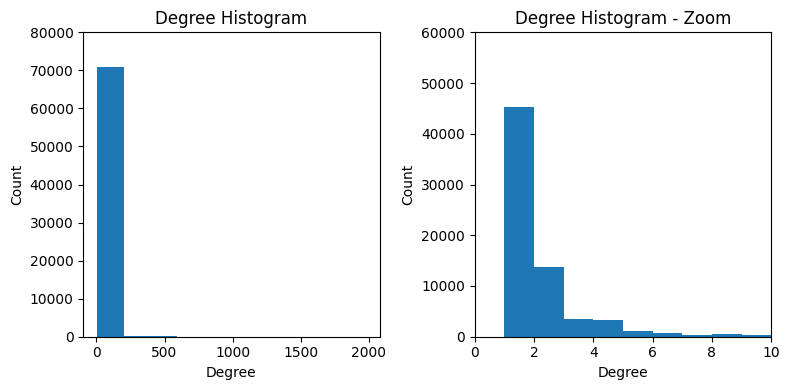

25963 nodes, 134093 edges
Nodes removed: 63.58%
Edges removed: 25.26%
Edges per nodes: 5.16
Exploring Centrality distributions - Degree
Exploring Centrality distributions - Degree - All Nodes


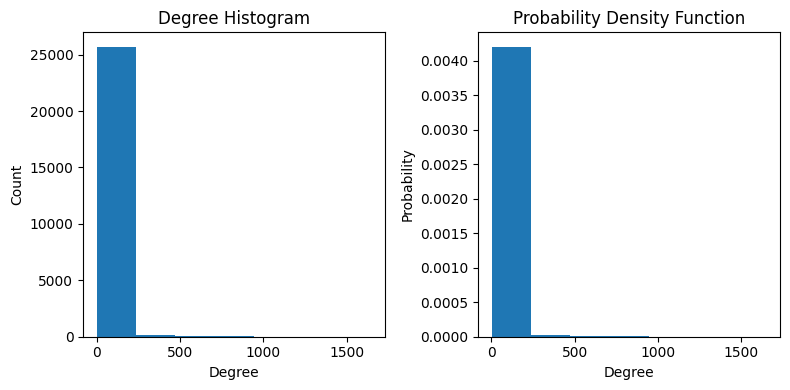

Ploting Probability Density Function (PDF) - All Nodes


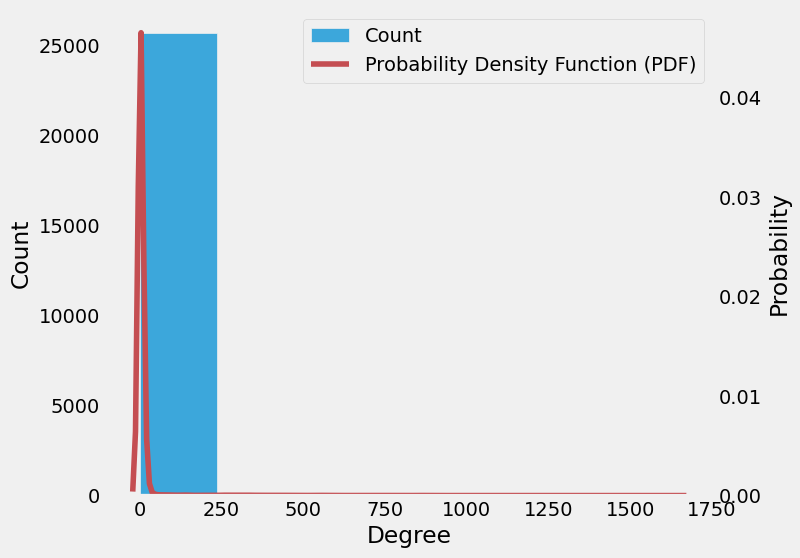

Ploting Cumulative Density Function (CDF) - All Nodes


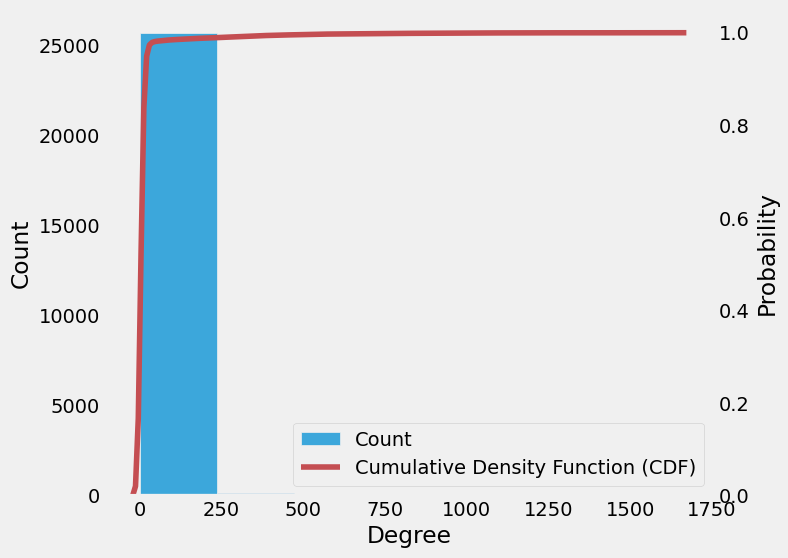

Exploring Centrality distributions - Degree - Nodes with degree greater than or equal to 100
394 nodes, 28722 edges


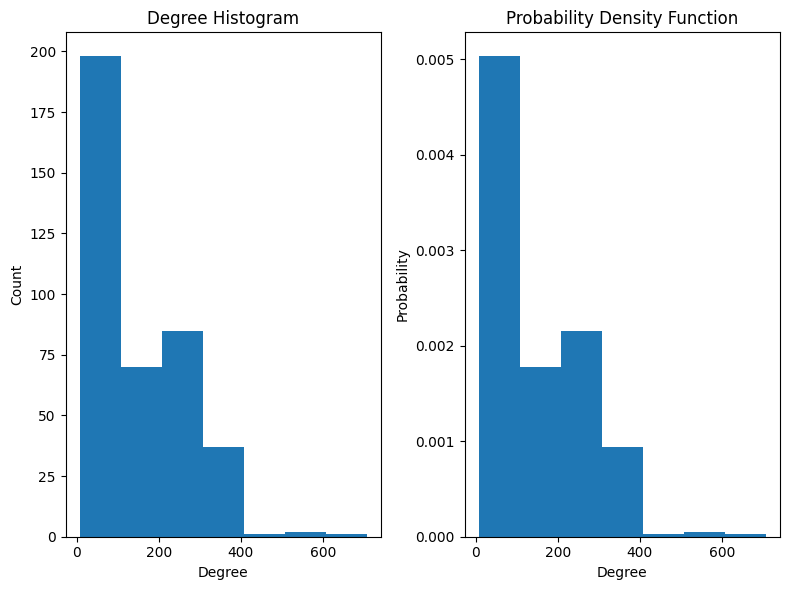

Ploting Probability Density Function (PDF) - Nodes 100


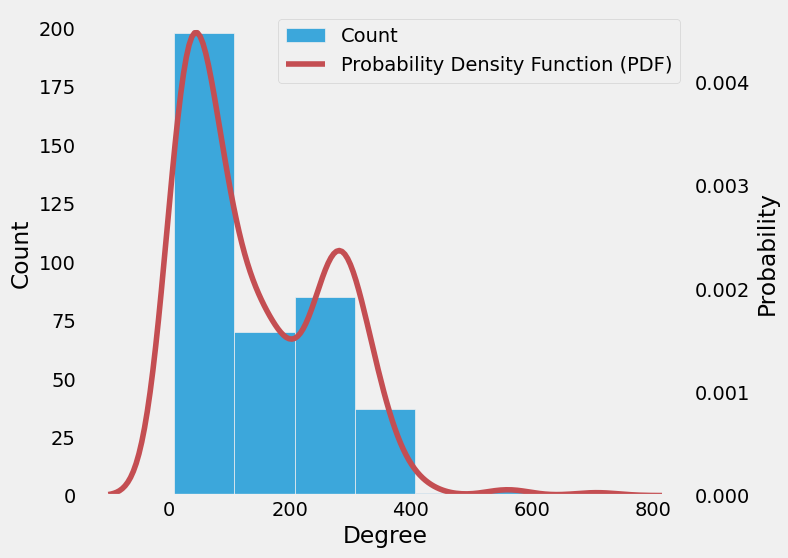

Ploting Cumulative Density Function (CDF) - Nodes 100


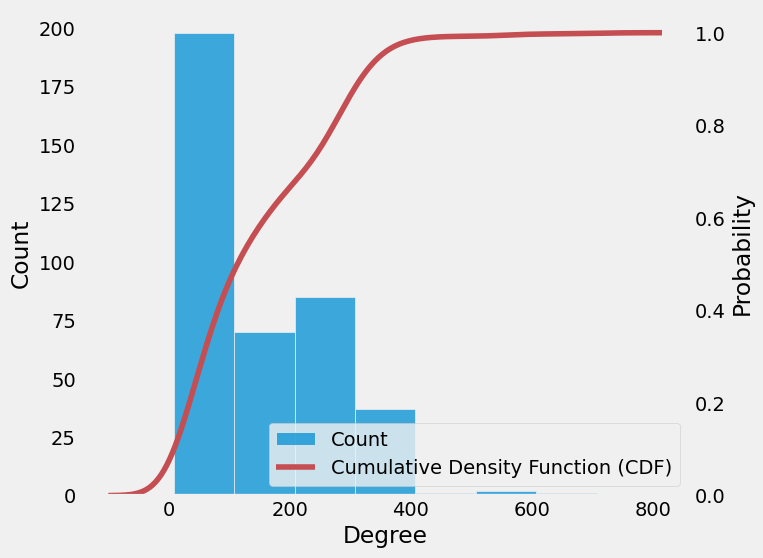

Exploring Centrality distributions - Closeness


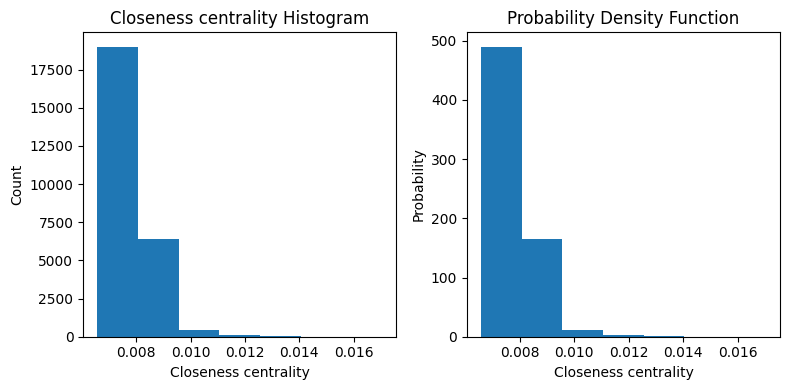

Ploting Probability Density Function (PDF) - Closeness


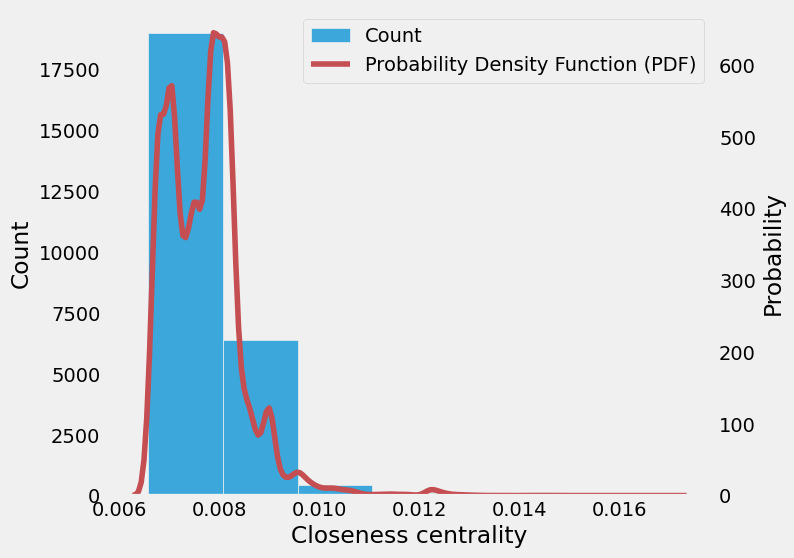

Ploting Cumulative Density Function (CDF) - Closeness


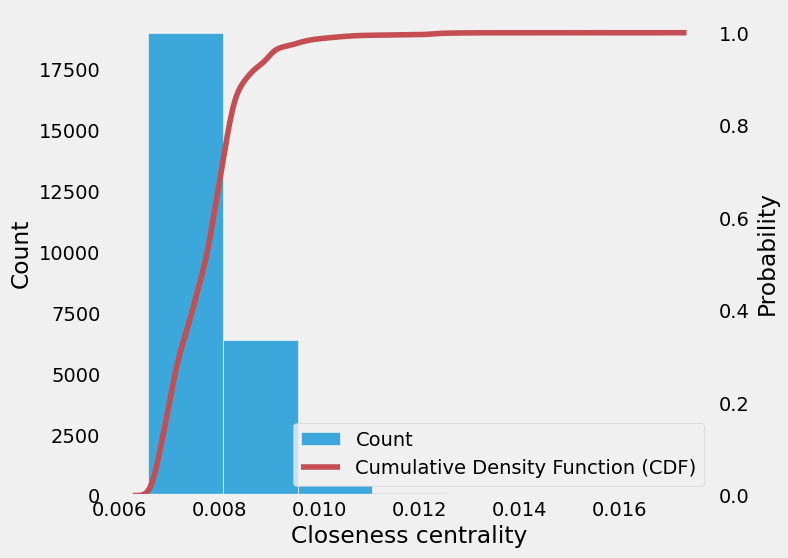

Exploring all metrics together


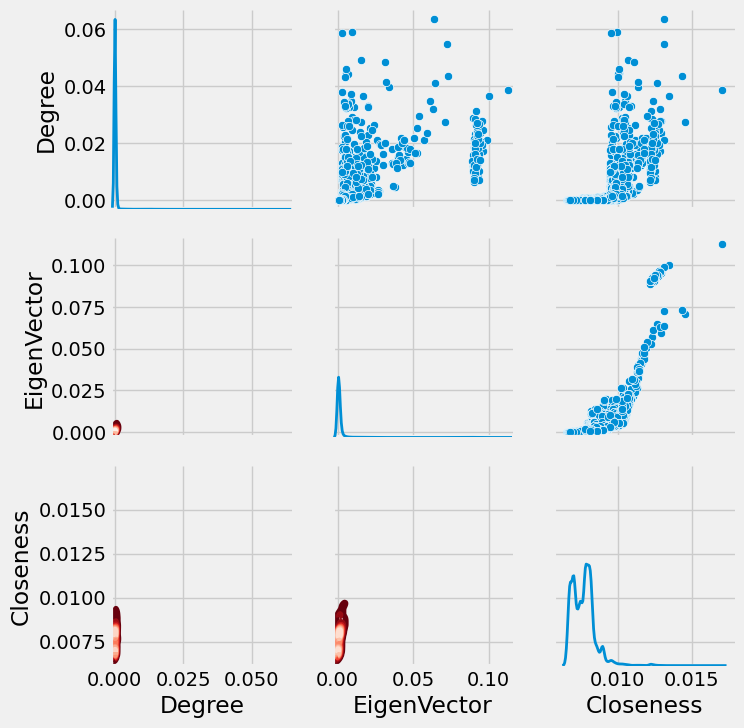

Exploring core composition
K-cores: {2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 61, 62, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 77, 78, 81, 86, 88, 89, 91, 93, 102, 104, 108, 110, 112, 113, 116, 117, 119, 120, 124, 125, 127, 130, 131, 132, 133, 135, 136, 140, 141, 143, 146, 147, 148, 154, 160}
K-cores length: 102
K-shell: ['Empire Of Brazil', 'Constitution Of Brazil', 'Mining In Brazil', 'Brazilian Cuisine', 'Television In Brazil', 'Sergipe', 'South Region, Brazil', 'Economic History Of Brazil', 'Brazilian Real', 'Administrative Divisions Of Brazil', 'Mato Grosso', 'Piauí', 'Foreign Relations Of Brazil', 'Law Of Brazil', 'Automotive Industry In Brazil', 'Youth In Brazil', 'Regions Of Brazil', 'Telecommunications In Brazil', 'Languages Of Brazil', 'Amapá', 'Pará', 'Amazonas (Brazilian State)', 'Brazilian Sculpture', 'Par

In [56]:
composed = compose(create_graph, preprocessing, truncate, explore_network)
composed(args)